## 랭그래프의 노드를 이루는 요소

- Agent : LLM을 사용해서 동작에 대한 판단을 스스로 내리는 AI 구성요소

- Tool : 단순 함수 Call

In [16]:
!pip install langchain openai langchain-community

In [17]:
import os, openai
from google.colab import userdata
from langchain.llms import OpenAI

os.environ['OPENAI_API_KEY'] = userdata.get("sesac7_openAI2")

In [18]:
from tempfile import tempdir
from langchain.llms import OpenAI

llm = OpenAI(temperature=0)
# 4.74
print(llm.predict('what is 2.1^2.1?'))

[llm/start] [llm:OpenAI] Entering LLM run with input:
{
  "prompts": [
    "what is 2.1^2.1?"
  ]
}
[llm/end] [llm:OpenAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "\n\nThe answer is approximately 4.41.",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "Generation"
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "completion_tokens": 10,
      "prompt_tokens": 11,
      "total_tokens": 21
    },
    "model_name": "gpt-3.5-turbo-instruct"
  },
  "run": null,
  "type": "LLMResult"
}


The answer is approximately 4.41.


In [19]:
from langchain.agents import Tool
from langchain.chains import LLMMathChain

# 동일한 세팅의 llm을 LLMMathChain에게 전달
llm_math = LLMMathChain(llm=OpenAI(temperature=0))

# 수학적 툴
math_tool = Tool(
    name = 'calculator',
    func = llm_math.run,
    description = '수학 계산과 관련된 문제에 대해 필요하면 이 도구를 쓰시오.'
)

tools = [math_tool]
print(tools[0].name, tools[0].description)

calculator 수학 계산과 관련된 문제에 대해 필요하면 이 도구를 쓰시오.


/tmp/ipython-input-1381266621.py:5: UserWarning: Directly instantiating an LLMMathChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  llm_math = LLMMathChain(llm=OpenAI(temperature=0))


In [20]:
# 위의 tool을 llm에 붙여 사용할 수 있게
!pip install langgraph langchain-openai

In [21]:
# agents "판단" / 실행을 하지는 않음
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import langchain

# model(생각할 llm, agent의 두뇌),
# tools(agent가 사용가능한 도규 목록),
# prompt(agent가 판단할 때 어떤 기준이 있다면? 이걸 프롬프트가 담고 있다.)
model = ChatOpenAI(model='gpt-3.5-turbo')
prompt = ChatPromptTemplate.from_messages([
    ('system', '너는 사용자를 도와주는 훌륭한 AI 어시스턴트야.'),
    ('human', '{input}'),
    ('placeholder', '{agent_scratchpad}')   # tools을 사용하면서 남기는 중간 작업 내역
])

# 디버깅 모드 활성화
# langchain.debug = True

# agent를 만듦 => 이 agent는 tool을 calling =>
# model(두뇌)로 tools(도구)를 prompt(지시사항)에 맞게 판단해서 부름
agent = create_tool_calling_agent(model, tools, prompt)

# 에이전트의 실행
agent_executor = AgentExecutor(agent=agent, tools=tools)
agent_executor.invoke({'input':'what is 2.1^2.1'})

[chain/start] [chain:AgentExecutor] Entering Chain run with input:
{
  "input": "what is 2.1^2.1"
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence] Entering Chain run with input:
{
  "input": ""
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad>] Entering Chain run with input:
{
  "input": ""
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad> > chain:RunnableParallel<agent_scratchpad>] Entering Chain run with input:
{
  "input": ""
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad> > chain:RunnableParallel<agent_scratchpad> > chain:RunnableLambda] Entering Chain run with input:
{
  "input": ""
}
[chain/end] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad> > chain:RunnableParallel<agent_scratchpad> > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": []
}
[chain/en

{'input': 'what is 2.1^2.1',
 'output': 'The result of \\(2.1^{2.1}\\) is approximately 4.749638091742242.'}

## 툴을 생성하는 방법

- 1. tool 데코레이터 사용하기
- 2. StructuredTool 이라는 클래스를 사용(복잡)

In [22]:
# tool 데코레이터를 사용해서 일반 함수를 '툴'로 인지시키기 위함
from langchain.tools import tool

# @(at) 파이썬에서는 얘를 데코레이터라고 함
# 함수, 클래스에 특정한 '기능을 추가하겠다'라는 약속
# @app.route() / @staticmethod
@tool
def write_mail(to:str, subject:str, content:str) -> str:
    """Write and Send an email""" # 툴에 대한 설명을 반드시 해줘야 함
    return f"Email sent to {to} with subject {subject}, and {content}"

type(write_mail)

langchain_core.tools.structured.StructuredTool

In [25]:
#만든 툴을 사용하자!
from langchain.chat_models import init_chat_model

#다양한 api를 넘나들며 쓸 수 있다.
llm = init_chat_model('openai:gpt-4.1', temperature=0)

#llm에 tools을 바인딩해줌
#tool_choice = 'any' llm이 필요한 도구(tool)을 자유롭게 선택해서 활용하세요. //none(툴 사용 X), auto(자동 판단)
#parallel_tool_calls = 에이전트가 한번에 '한개'/'여러개' 의 도구를 사용할 수 있게 함
model_with_tools = llm.bind_tools([write_mail],
                                  tool_choice='any',
                                  parallel_tool_calls=False)

output = model_with_tools.invoke("Draft a response to my coworker(jeongeunswd@gmail.com) about today's LangGraph lecture")
print(output)

content='' additional_kwargs={'tool_calls': [{'id': 'call_q75Sa29XckUVsaqgR8jFnWfg', 'function': {'arguments': '{"to":"jeongeunswd@gmail.com","subject":"Re: Today\'s LangGraph Lecture","content":"Hi Jeongeun,\\n\\nThank you for reaching out about today\'s LangGraph lecture. I found the session quite insightful, especially the parts about graph-based workflow orchestration and how LangGraph integrates with LLMs. If you have any specific questions or want to discuss any of the topics further, let me know! I\'d be happy to chat or share my notes.\\n\\nLooking forward to hearing your thoughts on the lecture.\\n\\nBest,\\n[Your Name]"}', 'name': 'write_mail'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 126, 'prompt_tokens': 71, 'total_tokens': 197, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_to

In [26]:
output.tool_calls[0]['args']

{'to': 'jeongeunswd@gmail.com',
 'subject': "Re: Today's LangGraph Lecture",
 'content': "Hi Jeongeun,\n\nThank you for reaching out about today's LangGraph lecture. I found the session quite insightful, especially the parts about graph-based workflow orchestration and how LangGraph integrates with LLMs. If you have any specific questions or want to discuss any of the topics further, let me know! I'd be happy to chat or share my notes.\n\nLooking forward to hearing your thoughts on the lecture.\n\nBest,\n[Your Name]"}

In [27]:
result = write_mail(output.tool_calls[0]['args'])
print(result)

Email sent to jeongeunswd@gmail.com with subject Re: Today's LangGraph Lecture, and Hi Jeongeun,

Thank you for reaching out about today's LangGraph lecture. I found the session quite insightful, especially the parts about graph-based workflow orchestration and how LangGraph integrates with LLMs. If you have any specific questions or want to discuss any of the topics further, let me know! I'd be happy to chat or share my notes.

Looking forward to hearing your thoughts on the lecture.

Best,
[Your Name]


/tmp/ipython-input-2047010431.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = write_mail(output.tool_calls[0]['args'])


## 랭그래프 구성 요소

- agent, tool => '기능'
- 노드(Nodes) : 정보를 어떻게 다룰 것인가(액션)
- 엣지(Edges) : 이 노드를 어떤 순서로 연결할 것인가 (흐름)
- 상태(State) : 랭그래프의 흐름에서 추적해야할 정보의 상태

In [28]:
# https://langchain-ai.github.io/langgraph/concepts/why-langgraph/
# 1. 기본적인 챗봇을 만듦(흐름)
# 2. 툴을 추가한다.
# 3. 메모리를 추가한다.
# 4. 사람 피드백을 추가한다.
# 5. 상태(State)를 커스터마이징 한다.

In [30]:
# 상태(State)에 대한 정의
# fastapi로 딥러닝 추론 코드 => typing/pydantic 자료형 고정시킴
# typing/pydantic -> TypedDict가 상태에 들어갈 구성요소의 '자료형'을 고정
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# 상태를 클래스로 만듦
class StateSchema(TypedDict):
    request : str
    email : str

# 나의 전체 LangGraph를 'workflow'라고 부를 것임
# 그리고 workflow는 StateSchema라는 클래스를 상태로 가질 것임
workflow = StateGraph(StateSchema)


In [31]:
# 노드 만들기
# 매개변수, 리턴값으로 State를 컨트롤하는 클래스를 받는다.
def write_email_node(state : StateSchema) -> StateSchema:
    # model_with_tools -> write_mail이라는 함수를 tool로 가진 llm
    output = model_with_tools.invoke(state['request'])

    # args 안에는 to, subject, content
    args = output.tool_calls[0]['args']

    # email -> 내가 요청한(request) 내용을 반영한 메일 초안
    email = write_mail.invoke(args)
    return {'email':email}

In [32]:
# 노드와 엣지를 '등록', '연결'
# add_node -> 함수를 노드로 인식하게 등록, (노드이름, 함수이름)
workflow.add_node('write_email',write_email_node)

# START -> 노드
# 노드 -> END
workflow.add_edge(START, 'write_email')
workflow.add_edge('write_email', END)

# 빌드 /컴파일
app = workflow.compile()

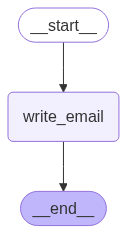

In [33]:
from IPython.display import Image, display

try:
  #우리가 만든 app의 graph를 이미지로 그려서 display()로 감싸 출력하는 함수
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [36]:
# START -> LLM -> (조건 판단) -> tool -> END
#                             -> ------> END
from typing import Literal
from langgraph.graph import MessagesState   # 위에 예제의 'StateGraph'역할을 대신 수행

# 1. LLM 노드를 구성할 함수 만들기
def call_LLM(state : MessagesState) -> MessagesState:
    """Run LLM""" # doctring(노드의 역할 설명)
    output = model_with_tools.invoke(state['messages'])
    return {'messages':[output]}

# def write_email_node(state : StateSchema) -> StateSchema:
#     # model_with_tools -> write_mail이라는 함수를 tool로 가진 llm
#     output = model_with_tools.invoke(state['request'])

#     # args 안에는 to, subject, content
#     args = output.tool_calls[0]['args']

#     # email -> 내가 요청한(request) 내용을 반영한 메일 초안
#     email = write_mail.invoke(args)
#     return {'email':email}

# 2. tool을 사용하는 노드를 구성하는 함수 만들기
def call_Tool(state : MessagesState) -> MessagesState:
    """Play the tool function"""
    # 툴을 썼을 때, 툴에 to, subject, content라는 요소/tool을 써서 어떻게 했다~ 라는 결과를 남겨놓 기 위해
    result = []
    # state['messages'][-1] == output
    for tool in state['messages'][-1].tool_calls:
        observations = write_mail.invoke(tool['args'])
        result.append({'role':'tool', 'content':observations, 'tool_call_id':tool['id']})
    return {'messages':result}

In [39]:
# START -> LLM -> (조건 판단) -> tool -> END
#                             -> ------> END
# 조건분기 판단 **리턴값이 특이함
# __init__ : 던더 함수(매직 메서드)
# END = __end__
def flow_check(state:MessagesState) -> Literal['call_Tool', '__end__']:
    """Route to tool handling, or end if don't need tool call"""
    message = state['messages']
    latest = message[-1]    # 상태 그래프가 가지고 있는 가장 최신의 정보를 get

    # 'tool을 call'했던 이력이 있냐 없냐? 있으면 -> call_tool, 없으면 -> END
    if latest.tool_calls:
        return 'call_Tool'
    else:
        return END

In [43]:
#노드를 순서대로 엮자!
#1. 상태 그래프를 정의한다.
workflow = StateGraph(MessagesState)

#2. 노드를 등록한다.
workflow.add_node('call_LLM', call_LLM)
workflow.add_node('call_Tool', call_Tool)

#3. 조건분기 등록
#컨디셔널엣지(시작점, 분기함수, {결과1:결과노드, 결과2:결과노드})
workflow.add_conditional_edges('call_LLM', flow_check, {'call_Tool':'call_Tool', END:END})

#4. 나머지 엣지 연결
workflow.add_edge(START, 'call_LLM')
workflow.add_edge('call_Tool', END)

app = workflow.compile()

In [44]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my coworker(jeongeunswd@gmail) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my coworker(jeongeunswd@gmail) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_mail (call_Agosg7FMbzo3JpiHJzxDHKTc)
 Call ID: call_Agosg7FMbzo3JpiHJzxDHKTc
  Args:
    to: jeongeunswd@gmail
    subject: Re: Interrupt! Attendance
    content: Hi,

Thank you for letting me know about Interrupt! I’d like to confirm that I want to attend. Please let me know if there’s anything I need to prepare or any further details I should know.

Looking forward to it!

Best,
[Your Name]
================================= Tool Message =================================

Email sent to jeongeunswd@gmail with subject Re: Interrupt! Attendance, and Hi,

Thank you for letting me know about Interrupt! I’d like to confirm that I want to attend. Please let me know if there’s anything I need to prepare or any further d